In [1]:
from src.reachability_analysis.labeling_oracle import LabelingOracleSINDData, LABELS
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np


In [2]:
from src.reachability_analysis.simulation import reachability_for_specific_position_and_mode
from src.reachability_analysis.zonotope import zonotope
from src.reachability_analysis.operations import visualize_zonotopes
from src.reachability_analysis.utils import filter_paddings

from typing import List, Union
import pypolycontain as pp

/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/pypolycontain/operations.py:23: UserWarning: You don't have pydrake installed properly. Methods that rely on optimization may fail.
  warnings.warn("You don't have pydrake installed properly. Methods that rely on optimization may fail.")
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/pypolycontain/conversions.py:19: UserWarning: WARNING: You don't have CDD package installed. Unable to visualize polytopes. You may still visualize zonotopes.
  warnings.warn("WARNING: You don't have CDD package installed. Unable to visualize polytopes. You may still visualize zonotopes.")
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/pypolycontain/conversions.py:32: UserWarning: You don't have pydrake installed properly. Methods that rely on optimization may fail.
  warnings.warn("You don't have pydrake installed properly. Methods that rely on optimization m

In [3]:
ROOT = os.getcwd()

In [4]:
def structure_input_data(data: np.ndarray, labels: np.ndarray):
    """Drops random trajectories such that the data for each class
    is of the same length

    Parameters:
    -----------
    data : np.ndarray
        The chunks from the dataset
    labels: np.ndarray
        The true labels for the data
    """
    _d = {}.fromkeys(labels)
    [_d.update({i: []}) for i in _d.keys()]
    [_d[_l].append(data[i]) for i, _l in enumerate(labels)]
    _lens = [len(v) for v in _d.values()]
    _min_len = min(_lens)
    new_d = []
    new_l = []
    for _l, _v in _d.items():
        _v = np.array(_v)
        _ids = np.random.randint(0, len(_v), size=_min_len)
        new_d = [*new_d, *_v[_ids]]
        new_l = [*new_l, *[_l] * _min_len]
    return np.array(new_d), np.array(new_l)

In [5]:
def separate_data_to_class(data: np.ndarray, classification: np.ndarray) -> np.ndarray:
    """ Separate the entire dataset into a list[list] where each nested list contain 
        the trajectories for that specific class.

        Parameters:
        -----------
        data : np.ndarray
            The entire dataset
        classification : np.ndarray
            The labels from the classification framework for the dataset in data
    """
    _class = [0] * len(LABELS)
    for _i in range(len(_class)): _class[_i] = []
    for i,_trajectory in enumerate(data):
        _class[classification[i]].append(_trajectory)
    return np.array(_class)


### My Data

In [40]:
# experiments/SINDDataset_pretrained_2024-04-19_22-22-05_bvW/checkpoints/model_best.pth
model_file = 'SINDDataset_pretrained_2024-04-19_22-22-05_bvW'

index = 2
index_data = 0
folder = 'experiments'

In [41]:
import json

with open(f'{folder}/{model_file}/configuration.json') as f:
    config = json.load(f)
    config['save_dir'] = ROOT + f'/{folder}/' + config['save_dir'].split('/', index)[-1]
    config['output_dir'] = ROOT + f'/{folder}/' + config['output_dir'].split('/', index)[-1]  + '/eval'
    config['tensorboard_dir'] = ROOT + f'/{folder}/' + config['tensorboard_dir'].split('/', index)[-1] + '/eval'
    config['data_dir'] = ROOT + '/' + config['data_dir'].split('/', index_data)[-1]
    config['load_model'] = config['save_dir'] +'/model_best.pth'
    config['eval_only'] = True
    config['save_embeddings'] = True
    config['val_ratio'] = 1.0
    config['dropout'] = 0.0  # No dropout during evaluation
    config['hyperparameter_tuning'] = False
    
config['data_chunk_len'] = 90

In [42]:
labeling_oracle = LabelingOracleSINDData(config)

2024-04-24 11:46:33,733 | INFO : Loading 24 datasets files using 20 parallel processes ...


In [43]:
dataset, padded_chunks = labeling_oracle.create_chunks()

In [44]:
# Find batches with no padding
unpadded_batches = np.all(padded_chunks, axis=1)  # True only for batches with all 1s (no padding)

# Filter the dataset to keep only completely unpadded batches
filtered_data = dataset[unpadded_batches]

labels = labeling_oracle.labels(filtered_data)

Labeling data:   0%|          | 0/4861 [00:00<?, ?it/s]

Labeling data: 100%|██████████| 4861/4861 [00:00<00:00, 6348.54it/s]


In [45]:
dataset.shape, padded_chunks.shape, filtered_data.shape, set(labels)

((6460, 90, 6), (6460, 90), (4861, 90, 6), {0, 1, 2, 3, 4, 5, 6})

In [46]:
data, l = structure_input_data(filtered_data, labels)
filtered_data.shape, labels.shape, data.shape, l.shape

((4861, 90, 6), (4861,), (168, 90, 6), (168,))

In [47]:
d = separate_data_to_class(data, l)
d.shape, l.shape # )7, 609, 504

((7, 24, 90, 6), (168,))

In [48]:
def get_initial_conditions(data: np.ndarray):
    x, y, vx, vy = data[-1][0], data[-1][1], data[-1][2], data[-1][3]
    pos = np.array([x, y])
    v = np.array([vx, vy])
    return pos, v

In [49]:
# Simulate and obtain zonotopes
specific_trajectory = data[0]
position, velocity = get_initial_conditions(specific_trajectory)
position, velocity, config['data_chunk_len'], l[0]

(array([12.42850049, 27.97594641]), array([-1.30031801,  0.03548613]), 90, 4)

Area of zonotope:  1159.6141  m^2
Area of (baseline) zonotope:  387.6124  m^2


/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


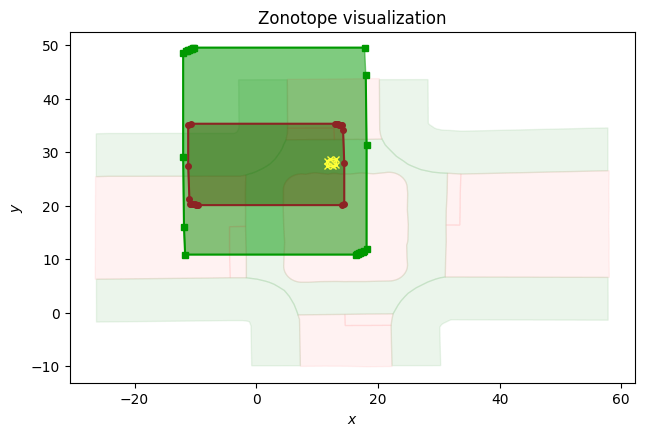

In [51]:
zonotopes = reachability_for_specific_position_and_mode(pos=position, vel=velocity, input_len=config['data_chunk_len'], c=l[0], d=d, sind=labeling_oracle, sim=True)

### Other data

In [6]:
from src.reachability_analysis.utils import load_data
from example_code.data.data_reader import SinD


In [7]:
input_len = 90
num_features =6

In [8]:
sind = SinD()
train_data = sind.data(input_len=input_len)
train_labels = sind.labels(train_data, input_len=90)
specific_trajectory, l_ = train_data[0], train_labels

Labeling data: 100%|██████████| 273602/273602 [00:36<00:00, 7488.17it/s]


In [9]:
train_data_new = train_data.reshape(train_data.shape[0], num_features, input_len).transpose(0, 2, 1)

In [10]:
train_data_, train_labels_ = structure_input_data(train_data_new, train_labels)
d_ = separate_data_to_class(train_data_, train_labels_)

In [11]:
# Simulate and obtain zonotopes
position, velocity = np.array([specific_trajectory[0: 90][-1], specific_trajectory[90: 2*90][-1]]), np.array([specific_trajectory[2*90: 3*90][-1], specific_trajectory[3*90: 4*90][-1]])
position, velocity, l_[0]

(array([21.22113128, 13.04062956]), array([0.02242433, 1.26726567]), 3)

In [12]:
train_data.shape, train_labels.shape, train_data_.shape, d_.shape, l_.shape

((273602, 540), (273602,), (5271, 90, 6), (7, 753, 90, 6), (273602,))

In [13]:
position, velocity, input_len, d_.shape, l_[0]

(array([21.22113128, 13.04062956]),
 array([0.02242433, 1.26726567]),
 90,
 (7, 753, 90, 6),
 3)

Area of zonotope:  826.9675  m^2
Area of (baseline) zonotope:  441.3691  m^2


/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


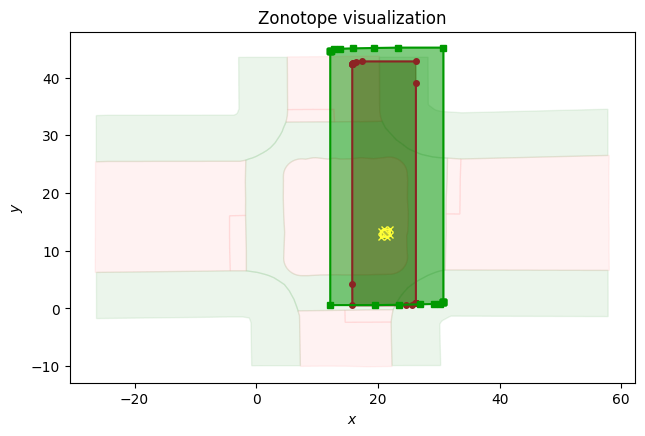

In [14]:
zonotopes = reachability_for_specific_position_and_mode(pos=position, vel=velocity, input_len=input_len, c=l_[0], d=d_, sind=sind, sim=True)

In [15]:
# def reachability_for_specific_position_and_mode(
#     pos: np.ndarray = np.array([-3.4, 28.3]),
#     c: int = 1,
#     vel: np.ndarray = np.array([1, 0]),
#     _baseline: bool = True,
#     _show_plot: bool = True,
#     _ax: plt.Axes = None,
#     _labels: list = None,
#     _suppress_prints: bool = False,
#     _sind_: SinD = None,
#     _d: np.ndarray = None,
#     sim: bool = False,
# ):
#     """Get reachable set for a specific position, mode and starting velocity

#     Parameters:
#     -----------
#     pos : np.ndarray
#     c : int
#     vel : np.ndarray
#     _baseline : bool
#     _show_plot : bool
#     _ax : plt.Axes
#     _labels : list
#     _suppress_prints : bool
#     _sind_ : SinD
#     _d : np.ndarray
#     """
#     input_len = 90
#     a = input_len - 1
#     if not _sind_:
#         _sind = SinD()
#     else:
#         _sind = _sind_
#     if type(_d) is not np.ndarray:
#         if input_len == 90:
#             data = load_data()
#             labels = load_data("sind_labels.pkl")
#             train_data, _, train_labels, _ = split_data(data, labels)
#         else:
#             data = _sind.data(input_len=input_len)
#             labels = _sind.labels(data, input_len=input_len)
#             train_data, _, train_labels, _ = split_data(data, labels)
#         train_data, train_labels = structure_input_data(train_data, train_labels)
#         d = separate_data_to_class(train_data, train_labels)
#     else:
#         d = _d
#     c_z = pos
#     G_z = np.array([[2, 0, 1], [0, 2, 0.6]])
#     z = zonotope(c_z, G_z)
#     v = vel
#     U, X_p, X_m, _ = create_io_state(
#         d, z, v, c, input_len=input_len, drop_equal=True, angle_filter=True
#     )
#     process_noise = 0.005
#     _, _, U_traj = split_io_to_trajs(X_p, X_m, U, threshold=5, dropped=True, N=a)
#     U_k = input_zonotope(U_traj, N=a)
#     z_w = zonotope(np.array([0, 0]), process_noise * np.ones(shape=(2, 1)))
#     M_w = create_M_w(U.shape[1], z_w, disable_progress_bar=sim)
#     G_z = np.array([[0.5, 0, 0.25], [0, 0.5, 0.15]])
#     z = zonotope(c_z, G_z)
#     R = LTI_reachability(U, X_p, X_m, z, z_w, M_w, U_k, N=a, disable_progress_bar=sim)
#     R_all = R
#     R = R[-1]
#     R.color = [0, 0.6, 0]
#     R_base_all = None
#     if _baseline:
#         U_all, X_p_all, X_m_all, _ = create_io_state(
#             d,
#             z,
#             v,
#             [0, 1, 2, 3, 4, 5, 6],
#             input_len=input_len,
#             drop_equal=True,
#             angle_filter=False,
#         )
#         _, _, U_all_traj = split_io_to_trajs(
#             X_p_all, X_m_all, U_all, threshold=5, dropped=True, N=a
#         )
#         U_k_all = input_zonotope(U_all_traj, N=a) # (list of 89 zonotopes)
#         M_w_base = create_M_w(U_all.shape[1], z_w, disable_progress_bar=sim)
#         R_base = LTI_reachability(
#             U_all,
#             X_p_all,
#             X_m_all,
#             z,
#             z_w,
#             M_w_base,
#             U_k_all,
#             N=a,
#             disable_progress_bar=sim,
#         )
#         R_base_all = R_base
#         R_base = R_base[-1]
#         R_base.color = [0.55, 0.14, 0.14]
#     if not _suppress_prints:
#         print("Area of zonotope: ", round(zonotope_area(R), 4), " m^2")
#         if _baseline:
#             print(
#                 "Area of (baseline) zonotope: ", round(zonotope_area(R_base), 4), " m^2"
#             )
#     z = zonotope(c_z, G_z)
#     if not _ax:
#         _ax, _ = _sind.map.plot_areas()
#     z.color = [1, 1, 55 / 255]
#     _zonos = [R_base, R, z] if _baseline else [R, z] # baseline zonotope red, proposed zonotope green, position person blue
#     if sim:
#         ax = visualize_zonotopes(_zonos, map=_ax, show=False, _labels=_labels)
#     else:
#         ax = None
#     if _show_plot:
#         plt.show()
#     return ax, _zonos, R_all, R_base_all

In [ ]:
# def split_io_to_trajs(X_p: np.ndarray, X_m: np.ndarray, U: np.ndarray, threshold: float = 0.8, dropped: bool = True, N: int = 30):
#     """ Split the IO state (that drops equal points) into trajectories of different sizes

#         Parameters:
#         -----------
#         X_p : np.ndarray
#             X+ data
#         X_m : np.ndarray
#             X- data
#         U : np.ndarray
#             Inputs
#         threshold : float (default = 0.8)
#             Threshold for when regarding two points on the same trajectory
#         dropped : bool (default = True)
#             Set this to True if the equal points have been dropped from
#             the data
#         N : int (default = 30)
#             Time horizon of the reachability analysis
#     """
#     _X_p, _X_m, _U = [], [], []
#     if dropped:
#         x_prev = X_p[:,0]
#         i_prev = 0
#         for i,x in enumerate(X_p[:,1:].T):
#             _dist = np.linalg.norm(x-x_prev)
#             x_prev = x
#             if _dist > threshold:
#                 _X_p.append(X_p[:,i_prev:i+1])
#                 _X_m.append(X_m[:,i_prev:i+1])
#                 _U.append(U[:,i_prev:i+1])
#                 i_prev = i+1
#     else:
#         for i in range(N, U.shape[1]+1, N):
#             _U.append(U[:,i-N:i])
#     if len(_U) == 0:
#         _X_p.append(X_p[:,i_prev:i+1])
#         _X_m.append(X_m[:,i_prev:i+1])
#         _U.append(U[:,i_prev:i+1])
#     return _X_p, _X_m, _U

In [ ]:
#  _, _zonos, R_all, _ = reachability_for_specific_position_and_mode(
#                 pos,
#                 _mode,
#                 vel,
#                 _baseline=baseline,
#                 _show_plot=False,
#                 _ax=ax,
#                 _suppress_prints=True,
#                 d=d_,
#                 sim=simulation,
#                 sind=_sind_,
#             )